<a href="https://colab.research.google.com/github/tops201/project_507/blob/main/507_508/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

#from google.colab import files #for google colab

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [4]:
#fetch dataset

#data_file = files.upload() #for google colab

#df = pd.read_excel(io.BytesIO(data_file["daily_field_data.xlsx"]), index_col="DATEPRD") #for google colab
df = pd.read_excel("daily_field_data.xlsx", index_col="DATEPRD") #for local IDE

date = df.index

df.head()

,BORE_GAS_VOL,BORE_OIL_VOL,BORE_WAT_VOL
DATEPRD,,,
39490,38888.67,284.65,385.01
39491,285246.16,1869.70,7.13
39492,509954.88,3124.09,1.16
39493,383426.67,2608.28,0.97
39494,418474.00,3051.80,4.89


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
scaled_df.head()

,BORE_GAS_VOL,BORE_OIL_VOL,BORE_WAT_VOL
DATEPRD,,,
39490,0.028509,0.028932,0.083855
39491,0.209112,0.197113,0.048727
39492,0.373844,0.330210,0.048172
39493,0.281087,0.275480,0.048154
39494,0.306780,0.322540,0.048518


In [6]:
#function to plot a series
def plot_series(x, y, format="-", start=None, end=None, label=None):
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Oil Volume")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#clear session 
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

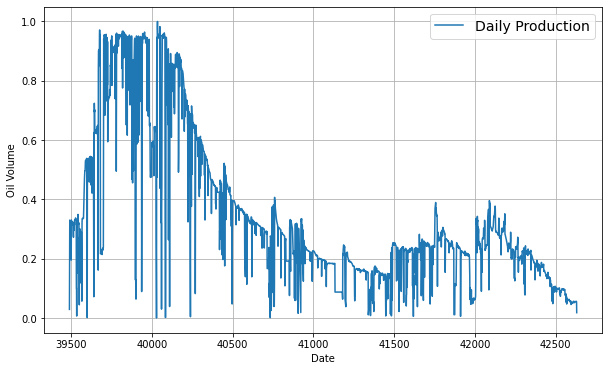

array([0.02893164, 0.19711331, 0.33021031, ..., 0.05548122, 0.05499314,
       0.017832  ])

In [7]:
oil_data = scaled_df.BORE_OIL_VOL.to_numpy()
oil_cum = np.cumsum(oil_data)

plt.figure(figsize=(10, 6))
plot_series(date, oil_data, label="Daily Production")
plt.show()

oil_data

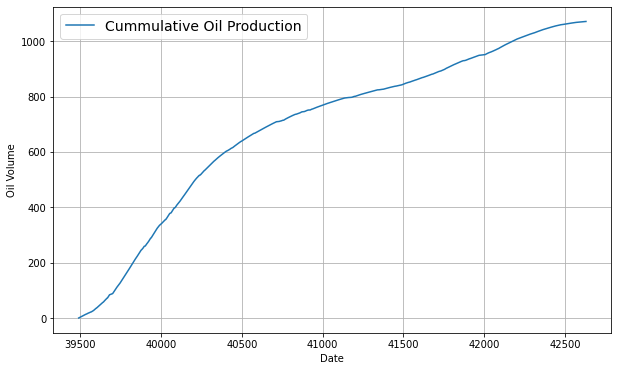

In [8]:
plt.figure(figsize=(10, 6))
plot_series(date, oil_cum, label="Cummulative Oil Production")
plt.show()

In [9]:
#split the time series into training and validation sets
split_date = 2750

date_train = date[:split_date]
date_valid = date[split_date:]

x_train = oil_data[:split_date]
x_valid = oil_data[split_date:]

print(x_train.shape, x_valid.shape, date_train.shape, date_valid.shape)

(2750,) (306,) (2750,) (306,)


# NAIVE Forecast

In [10]:
naive_forecast = oil_data[split_date - 1:-1]

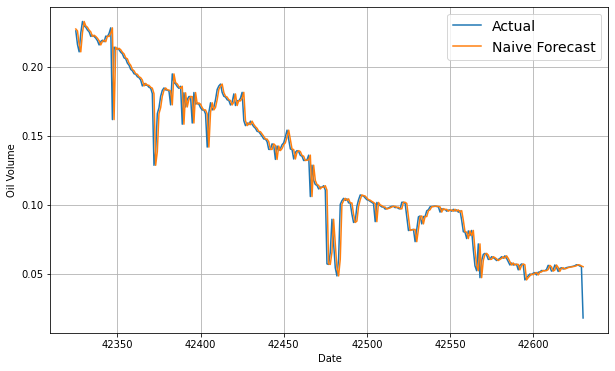

In [24]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, naive_forecast, label="Naive Forecast")

plt.show()

In [21]:
mae = keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
mse = keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

mae = 0.004702322219421191, 
mse = 9.484648724355615e-05, 
rmse = 0.009738916122626591


# Moving Average

In [22]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    
    return mov[window_size - 1:-1] / window_size

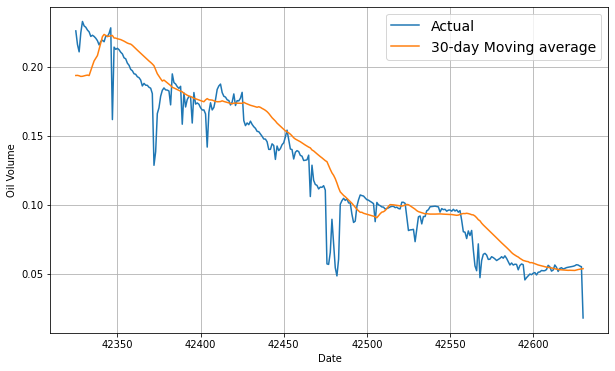

In [23]:
moving_avg = moving_average_forecast(oil_data, 30)[split_date - 30:]

plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, moving_avg, label="30-day Moving average")

plt.show()

In [25]:
mae = keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
mse = keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

mae = 0.012288786949989451, 
mse = 0.0003178901941009895, 
rmse = 0.017829475429776094


# Linear Model

In [65]:
def window_dataset(series, window_size, batch_size=30, shuffle_buffer=100):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(2)
    
    return dataset


def model_forecast(model, series, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(30).prefetch(2)
    
    forecast = model.predict(dataset)
    
    return forecast

In [57]:
refresh()

window_size = 30

train_set = window_dataset(x_train, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

lr_schedule = LearningRateScheduler(
                lambda epoch: 1e-4 * 10**(epoch / 30)
                )

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
91/91 [==============================] - 2s 6ms/step - loss: 0.2141 - mae: 0.5061
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0783 - mae: 0.2698
Epoch 3/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0278 - mae: 0.1490
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0156 - mae: 0.1107
Epoch 5/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0129 - mae: 0.1017
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0122 - mae: 0.0998
Epoch 7/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0120 - mae: 0.0990A: 0s - loss: 0.0135 - mae: 0.10
Epoch 8/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0119 - mae: 0.0980A: 0s - loss: 0.0138 - mae: 0.10
Epoch 9/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0117 - mae: 0.0971
Epoch 10/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0116 - mae: 0.

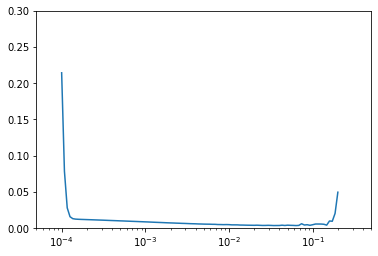

0.21413861215114594

In [61]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([5e-5, 5e-1, 0, 0.3])

plt.show()

max(history.history["loss"])

In [77]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(
    
    train_set,
    epochs=500,
    validation_data=valid_set,
    callbacks=[early_stopping]

)


Epoch 1/500
91/91 [==============================] - 2s 14ms/step - loss: 0.1240 - mae: 0.3255 - val_loss: 0.0014 - val_mae: 0.0489
Epoch 2/500
91/91 [==============================] - 1s 9ms/step - loss: 0.0195 - mae: 0.1141 - val_loss: 5.3121e-04 - val_mae: 0.0274
Epoch 3/500
91/91 [==============================] - 1s 7ms/step - loss: 0.0190 - mae: 0.1139 - val_loss: 4.8160e-04 - val_mae: 0.0259
Epoch 4/500
91/91 [==============================] - 1s 7ms/step - loss: 0.0183 - mae: 0.1108 - val_loss: 4.0481e-04 - val_mae: 0.0234
Epoch 5/500
91/91 [==============================] - 1s 8ms/step - loss: 0.0176 - mae: 0.1086 - val_loss: 3.9151e-04 - val_mae: 0.0229
Epoch 6/500
91/91 [==============================] - 1s 7ms/step - loss: 0.0169 - mae: 0.1060 - val_loss: 3.5409e-04 - val_mae: 0.0216
Epoch 7/500
91/91 [==============================] - 1s 9ms/step - loss: 0.0164 - mae: 0.1037 - val_loss: 3.2744e-04 - val_mae: 0.0206
Epoch 8/500
91/91 [==============================] - 1s 7m

In [78]:
lin_forecast = model_forecast(model, oil_data[split_date - window_size:-1], window_size)[:, 0]

lin_forecast.shape

(306,)

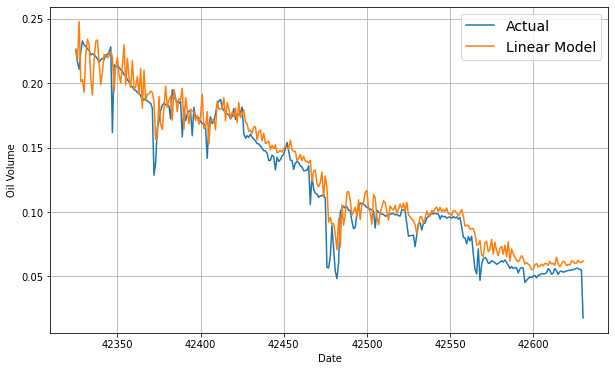

In [79]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, lin_forecast, label="Linear Model")

plt.show()

In [80]:
mae = keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()
mse = keras.metrics.mean_squared_error(x_valid, lin_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

mae = 0.009706021286547184, 
mse = 0.00018062932940665632, 
rmse = 0.013439841122820475


In [81]:
model.summary()
print(model.trainable_variables)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 1) dtype=float32, numpy=
array([[ 0.08188517],
       [ 0.05960739],
       [-0.22434801],
       [ 0.02890524],
       [ 0.11397316],
       [ 0.07813276],
       [-0.01565547],
       [-0.0450282 ],
       [-0.00504929],
       [ 0.02782605],
       [ 0.15289819],
       [-0.25722447],
       [ 0.2582654 ],
       [-0.22421978],
       [ 0.11428978],
       [-0.09582251],
       [ 0.08637023],
       [ 0.12289331],
       [-0.21201073],
       [ 0.1524517 ],
       [ 0.04066899],
       [-0.15466695],
       [ 0.26836708],
       [-0.22772619],
       [-0.0752493 ],
       [ 0.16834204],
       [ 0.1936

#  MLP

In [84]:
refresh()

window_size = 30

train_set = window_dataset(x_train, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
91/91 [==============================] - 2s 5ms/step - loss: 0.1052 - mae: 0.3725
Epoch 2/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0885 - mae: 0.3376
Epoch 3/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0726 - mae: 0.3015
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.0583 - mae: 0.2653
Epoch 5/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0458 - mae: 0.2305
Epoch 6/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0355 - mae: 0.1979
Epoch 7/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0271 - mae: 0.1682
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0207 - mae: 0.1420
Epoch 9/100
91/91 [==============================] - 1s 5ms/step - loss: 0.0160 - mae: 0.1200
Epoch 10/100
91/91 [==============================] - 0s 5ms/step - loss: 0.0127 - mae: 0.1036A: 0s - loss: 0.0326 - mae
Epoch 11/100
91/91 [=============

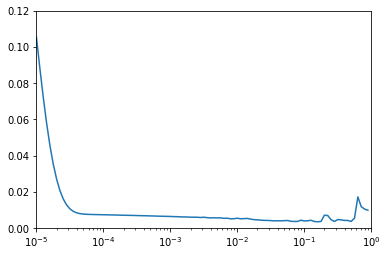

0.8912509

In [87]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 0.12])

plt.show()

max(history.history["lr"])

In [91]:
refresh()

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
91/91 [==============================] - 4s 24ms/step - loss: 0.0312 - mae: 0.1674 - val_loss: 9.5799e-04 - val_mae: 0.0399
Epoch 2/500
91/91 [==============================] - 1s 10ms/step - loss: 0.0086 - mae: 0.0819 - val_loss: 4.6269e-04 - val_mae: 0.0254
Epoch 3/500
91/91 [==============================] - 1s 11ms/step - loss: 0.0084 - mae: 0.0816 - val_loss: 4.1365e-04 - val_mae: 0.0237
Epoch 4/500
91/91 [==============================] - 1s 13ms/step - loss: 0.0081 - mae: 0.0785 - val_loss: 3.6577e-04 - val_mae: 0.0220
Epoch 5/500
91/91 [==============================] - 1s 11ms/step - loss: 0.0078 - mae: 0.0768 - val_loss: 3.5024e-04 - val_mae: 0.0215
Epoch 6/500
91/91 [==============================] - 1s 10ms/step - loss: 0.0076 - mae: 0.0749 - val_loss: 3.3842e-04 - val_mae: 0.0213
Epoch 7/500
91/91 [==============================] - 1s 10ms/step - loss: 0.0074 - mae: 0.0732 - val_loss: 3.1865e-04 - val_mae: 0.0207
Epoch 8/500
91/91 [=============================

In [92]:
dense_forecast = model_forecast(
                    model,
                    oil_data[split_date - window_size:-1],
                    window_size)[:, 0]

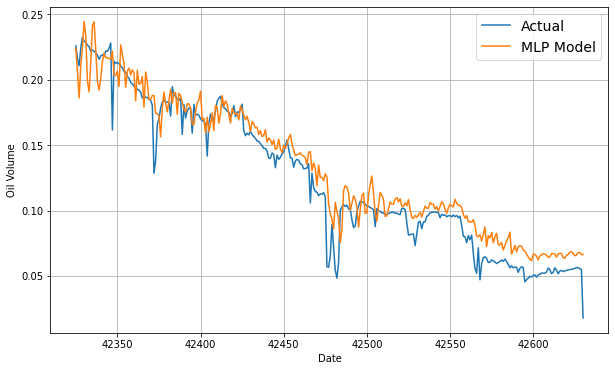

In [93]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid, label="Actual")
plot_series(date_valid, dense_forecast, label="MLP Model")

plt.show()

In [94]:
mae = keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()
mse = keras.metrics.mean_squared_error(x_valid, dense_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

mae = 0.01220634113997221, 
mse = 0.0002447806182317436, 
rmse = 0.01564546637948973


In [95]:
model.summary()
print(model.trainable_variables)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 10) dtype=float32, numpy=
array([[ 2.18016356e-01,  9.53972787e-02, -3.73882234e-01,
        -1.14936695e-01,  2.04220624e-03, -9.36639532e-02,
        -3.01182419e-01, -3.70745003e-01, -1.68804243e-01,
        -2.24156082e-02],
       [ 1.76869392e-01, -3.33945513e-01,  3.35203528e-01,
        -2.22872332e-01,  1.47150576e-01, -2.92100459e-02,

# RNN Model - LSTM

In [29]:
def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)

In [30]:
refresh()

window_size = 30

train_set = sequential_window_dataset(x_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        #Lambda(lambda x: x * 200.0)
    
        ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

Epoch 1/100
91/91 [==============================] - 10s 26ms/step - loss: 0.1192 - mae: 0.4041
Epoch 2/100
91/91 [==============================] - 2s 22ms/step - loss: 0.1192 - mae: 0.4041
Epoch 3/100
91/91 [==============================] - 2s 23ms/step - loss: 0.1192 - mae: 0.4041: 0s - loss: 0.1479 - m
Epoch 4/100
91/91 [==============================] - 2s 23ms/step - loss: 0.1192 - mae: 0.4041: 0s - loss: 0.1428 - mae
Epoch 5/100
91/91 [==============================] - 2s 22ms/step - loss: 0.1192 - mae: 0.4041
Epoch 6/100
91/91 [==============================] - 3s 28ms/step - loss: 0.1192 - mae: 0.4040:
Epoch 7/100
91/91 [==============================] - 2s 26ms/step - loss: 0.1192 - mae: 0.4040
Epoch 8/100
91/91 [==============================] - 2s 24ms/step - loss: 0.1192 - mae: 0.4040: 1s -
Epoch 9/100
91/91 [==============================] - 2s 25ms/step - loss: 0.1192 - mae: 0.4039
Epoch 10/100
91/91 [==============================] - 2s 25ms/step - loss: 0.1192 - mae: 

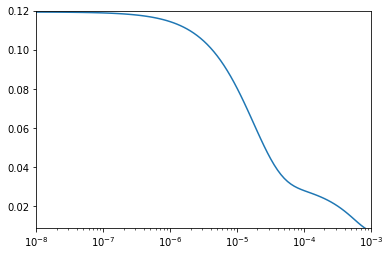

0.00089125097

In [34]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0.009, 0.12])
plt.show()

max(history.history["lr"])

In [35]:
refresh()

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1),
        #Lambda(lambda x: x * 200.0)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
91/91 [==============================] - 10s 44ms/step - loss: 0.0664 - mae: 0.2672 - val_loss: 0.0063 - val_mae: 0.1018
Epoch 2/500
91/91 [==============================] - 2s 24ms/step - loss: 0.0304 - mae: 0.1919 - val_loss: 0.0046 - val_mae: 0.0865
Epoch 3/500
91/91 [==============================] - 2s 25ms/step - loss: 0.0251 - mae: 0.1731 - val_loss: 0.0034 - val_mae: 0.0741
Epoch 4/500
91/91 [==============================] - 2s 24ms/step - loss: 0.0205 - mae: 0.1550 - val_loss: 0.0024 - val_mae: 0.0617
Epoch 5/500
91/91 [==============================] - 2s 24ms/step - loss: 0.0167 - mae: 0.1379 - val_loss: 0.0016 - val_mae: 0.0503
Epoch 6/500
91/91 [==============================] - 2s 23ms/step - loss: 0.0136 - mae: 0.1221 - val_loss: 0.0011 - val_mae: 0.0402
Epoch 7/500
91/91 [==============================] - 2s 24ms/step - loss: 0.0111 - mae: 0.1078 - val_loss: 6.9260e-04 - val_mae: 0.0320
Epoch 8/500
91/91 [==============================] - 2s 23ms/step - los

In [36]:
#load best model
model = keras.models.load_model("my_checkpoint.h5")

In [37]:
#forcast
rnn_forecast = model.predict(oil_data[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_date - 1:-1, 0]

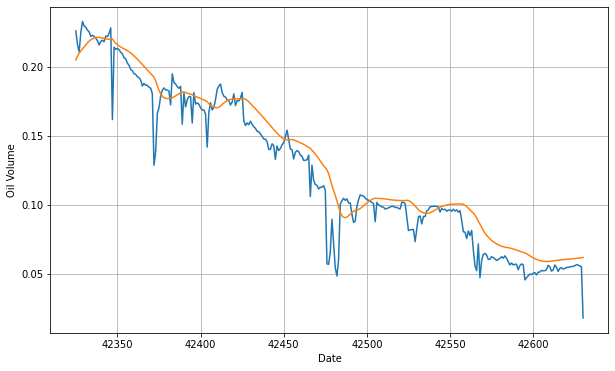

In [40]:
plt.figure(figsize=(10, 6))
plot_series(date_valid, x_valid)
plot_series(date_valid, rnn_forecast)

plt.show()

In [39]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.0109032